# Recreation of UNet
It is only for learning purposes: for CNNs and for Pytorch.

In [7]:
import os
import random
from PIL import Image
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from tqdm import tqdm
from matplotlib import pyplot as plt

print(torch.__version__)          # should show 2.8.0+cu126
print(torch.version.cuda)         # should show '12.6'
print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # NVIDIA RTX A6000

2.8.0+cu126
12.6
True
NVIDIA RTX A6000


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 1

if device == "cuda":
    print("Using GPU")
    num_workers = torch.cuda.device_count() * 4
else:
    print("Using CPU")

generator = torch.Generator().manual_seed(25)

Using GPU


In [9]:
DATA_DIR = "data/"
DATASET_DIR = DATA_DIR + "carvana/"
TRAIN_DIR = DATASET_DIR + "train/"
TRAIN_MASKS_DIR = DATASET_DIR + "train_masks/"

STATES_DIR = "states/"
MODEL_PATH = STATES_DIR + "carvana.pth"
IMAGE_SIZE = 512

In [10]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
EPOCHS = 5

## UNet classes (parts)
### Structure elements

In [11]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(DownSample, self).__init__()
        self.conv = Block(in_channels, out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        :return: the tensor before pooling (tensor to be copied) and the tensor after pooling (result)
        """
        y = self.conv(x)
        p = self.pool(y)
        return y, p

In [13]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = Block(in_channels, out_channel)

    def forward(self, x1, x2):
        """
        :param x1: the copied tensor from the downsampling
        :param x2: the tensor from the previous layer
        """
        x2 = self.up(x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.down_conv1 = DownSample(in_channels, 64)
        self.down_conv2 = DownSample(64, 128)
        self.down_conv3 = DownSample(128, 256)
        self.down_conv4 = DownSample(256, 512)

        self.bottle_neck = Block(512, 1024)

        self.up_conv1 = UpSample(1024, 512)
        self.up_conv2 = UpSample(512, 256)
        self.up_conv3 = UpSample(256, 128)
        self.up_conv4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # the s params are the saved tensors that will be concatenated at the upsampling stage
        s1, down1 = self.down_conv1(x)
        s2, down2 = self.down_conv2(down1)
        s3, down3 = self.down_conv3(down2)
        s4, down4 = self.down_conv4(down3)

        b = self.bottle_neck(down4)

        up1 = self.up_conv1(s4, b)
        up2 = self.up_conv2(s3, up1)
        up3 = self.up_conv3(s2, up2)
        up4 = self.up_conv4(s1, up3)

        return self.out(up4)

### Dataset
Using Carvana dataset for testing (https://www.kaggle.com/c/carvana-image-masking-challenge)

#### Get data

##### Get data

In [58]:
class GetDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "train/" + i for i in os.listdir(root_path + "train/")])[:self.limit]
        self.masks = sorted([root_path + "train_masks/" + i for i in os.listdir(root_path + "train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Normalize(mean=0, std=1),
            transforms.ToTensor()
        ])

        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        return min(len(self.images), self.limit)

In [20]:
train_dataset = GetDataset(DATASET_DIR)

#### Split and load it

In [23]:
# split dataset in train, test and validation batch (80% train, 10% test, 10% validation)
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [24]:
# num_workers is set to 0 here because notebook cannot load data in multithreading
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=0, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=0, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=0, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

## Learning

In [25]:
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [26]:
def dice(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    d = (2. * intersection + epsilon) / (union + epsilon)

    return d

In [31]:
def free_cache():
    # release unused CUDA memory
    torch.cuda.empty_cache()

In [48]:
def train(save=True, path=MODEL_PATH):
    t_losses = []
    t_dcs = []
    v_losses = []
    v_dcs = []

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        train_running_dc = 0

        idx = 0
        for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            optimizer.zero_grad()

            dc = dice(y_pred, mask)
            loss = criterion(y_pred, mask)

            train_running_loss += loss.item()
            train_running_dc += dc.item()

            loss.backward()
            optimizer.step()

        train_loss = train_running_loss / (idx + 1)
        train_dc = train_running_dc / (idx + 1)

        t_losses.append(train_loss)
        t_dcs.append(train_dc)

        model.eval()
        val_running_loss = 0
        val_running_dc = 0

        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)

                y_pred = model(img)
                loss = criterion(y_pred, mask)
                dc = dice(y_pred, mask)

                val_running_loss += loss.item()
                val_running_dc += dc.item()

            val_loss = val_running_loss / (idx + 1)
            val_dc = val_running_dc / (idx + 1)

        v_losses.append(val_loss)
        v_dcs.append(val_dc)

        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
        print("-" * 30)

    if save:
        # Saving the model
        torch.save(model.state_dict(), path)

    return t_losses, t_dcs, v_losses, v_dcs

In [49]:
free_cache()
train_losses, train_dcs, val_losses, val_dcs = train(True, path=STATES_DIR + "carvana2.pth")
free_cache()

 20%|██        | 1/5 [02:04<08:17, 124.41s/it]

------------------------------
Training Loss EPOCH 1: 0.0112
Training DICE EPOCH 1: 0.9897
Validation Loss EPOCH 1: 0.0107
Validation DICE EPOCH 1: 0.9900
------------------------------


 40%|████      | 2/5 [04:10<06:15, 125.16s/it]

------------------------------
Training Loss EPOCH 2: 0.0317
Training DICE EPOCH 2: 0.9714
Validation Loss EPOCH 2: 0.0126
Validation DICE EPOCH 2: 0.9883
------------------------------


 60%|██████    | 3/5 [06:16<04:11, 125.73s/it]

------------------------------
Training Loss EPOCH 3: 0.0148
Training DICE EPOCH 3: 0.9868
Validation Loss EPOCH 3: 0.0109
Validation DICE EPOCH 3: 0.9898
------------------------------


 80%|████████  | 4/5 [08:22<02:05, 125.94s/it]

------------------------------
Training Loss EPOCH 4: 0.0106
Training DICE EPOCH 4: 0.9903
Validation Loss EPOCH 4: 0.0100
Validation DICE EPOCH 4: 0.9906
------------------------------


100%|██████████| 5/5 [10:26<00:00, 125.24s/it]

------------------------------
Training Loss EPOCH 5: 0.0103
Training DICE EPOCH 5: 0.9905
Validation Loss EPOCH 5: 0.0100
Validation DICE EPOCH 5: 0.9905
------------------------------


## Testing

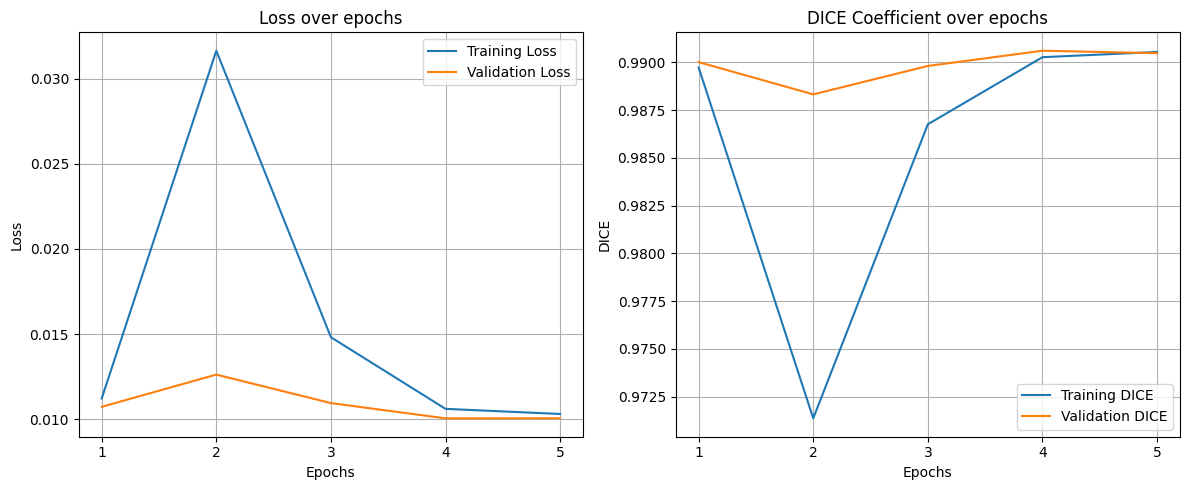

In [50]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
def load(path):
    m = UNet(in_channels=3, num_classes=1).to(device)
    m.load_state_dict(torch.load(path, map_location=torch.device(device)))
    return m

In [38]:
# trained_model = load(MODEL_PATH)
trained_model = load(STATES_DIR + "carvana2.pth")

In [39]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)

print(f'Loss: {test_loss:.4f}, DICE: {test_dc:.4f}')

100%|██████████| 41/41 [00:13<00:00,  3.00it/s]

Loss: 0.0148, DICE: 0.9863


In [70]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)

        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)

        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)

        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice(pred_mask.detach(), mask.detach())),5)}")

        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.subplot(133), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.show()

In [41]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])
    image_paths.append(random_sample[2])

Image: dd70a0a51e3b_16.jpg, DICE coefficient: 0.99221


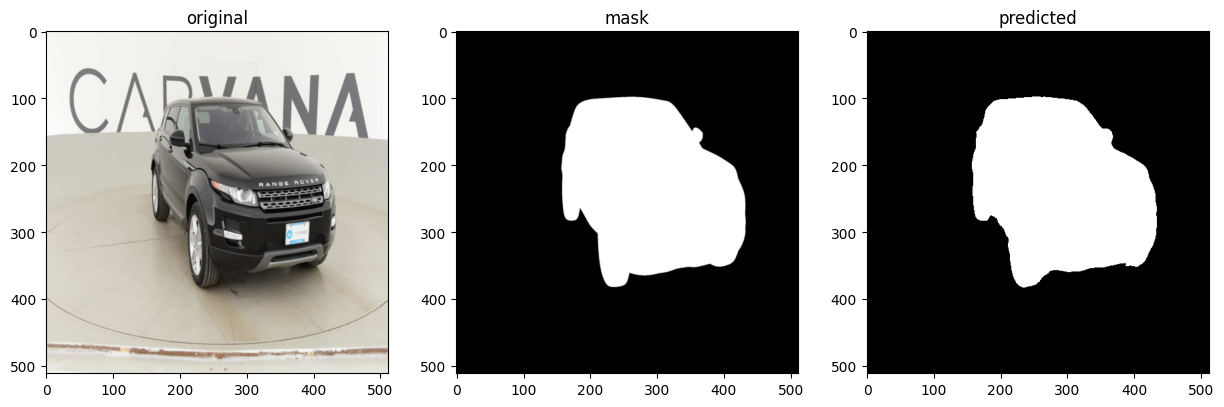

Image: a2df64508b97_03.jpg, DICE coefficient: 0.99341


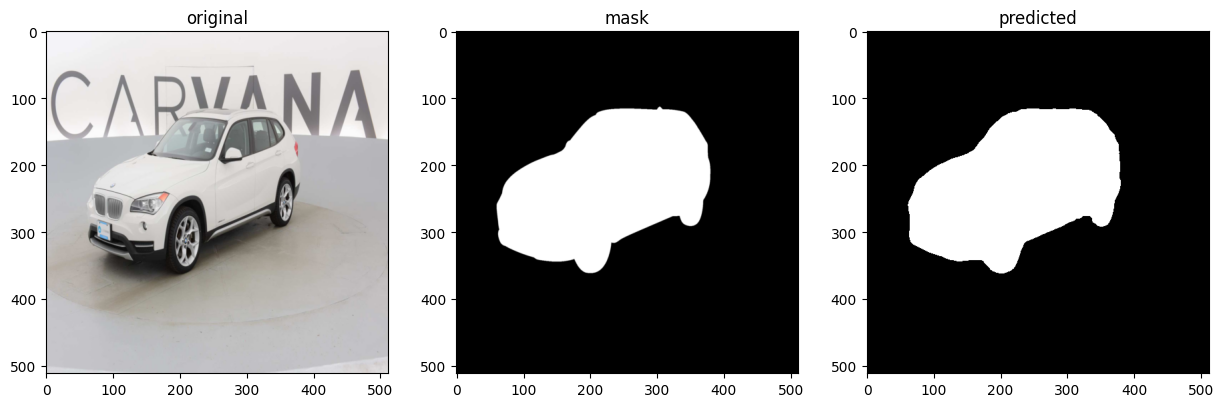

Image: 316bbfd3d93d_10.jpg, DICE coefficient: 0.98893


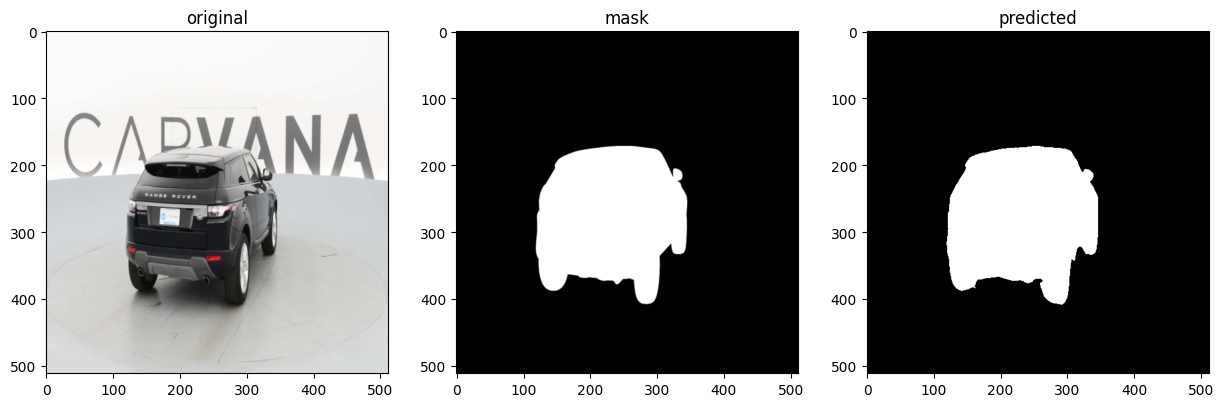

Image: 54ee69d7d5e5_07.jpg, DICE coefficient: 0.99008


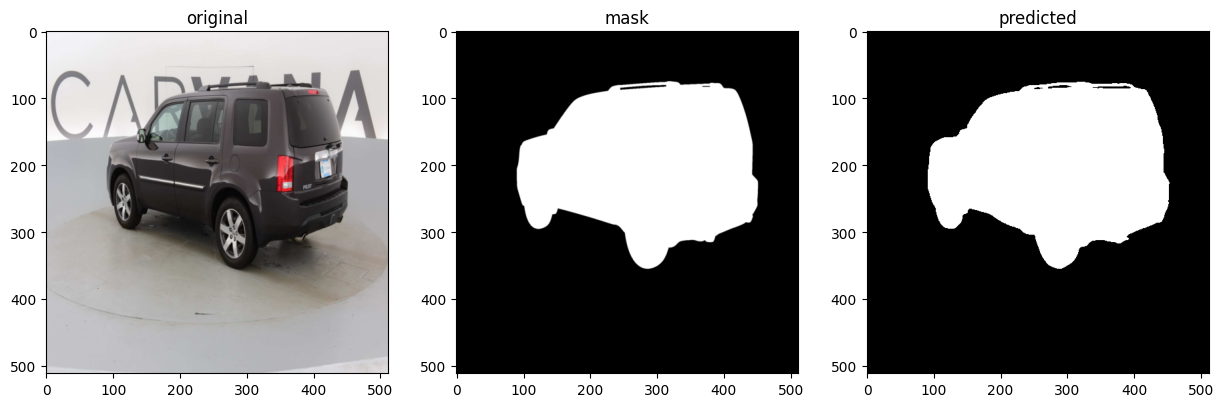

Image: 430f0cb5666c_16.jpg, DICE coefficient: 0.98889


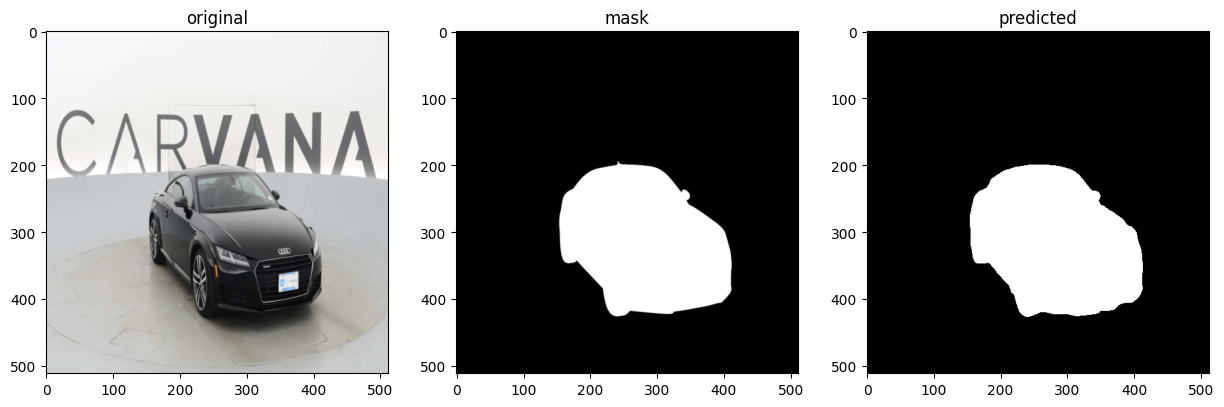

Image: 66fea07e1152_15.jpg, DICE coefficient: 0.99275


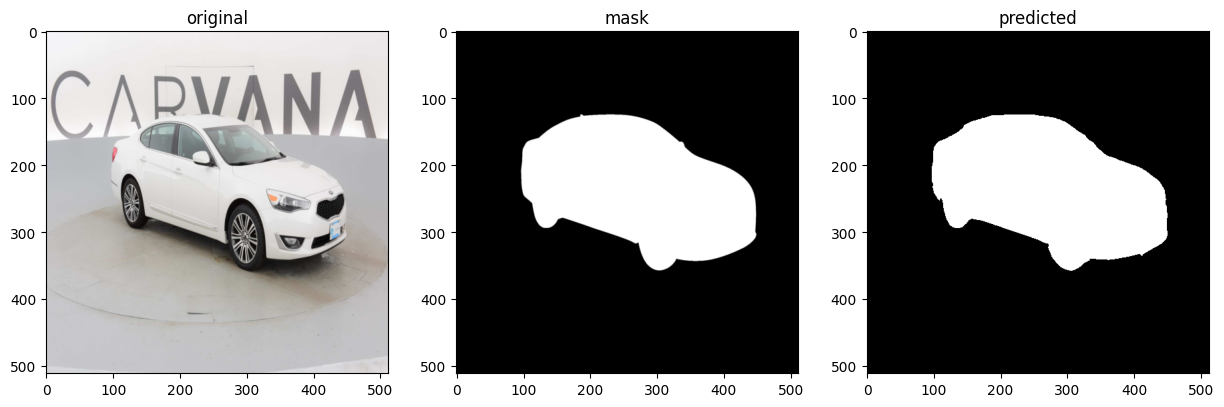

Image: efaef69e148d_05.jpg, DICE coefficient: 0.99382


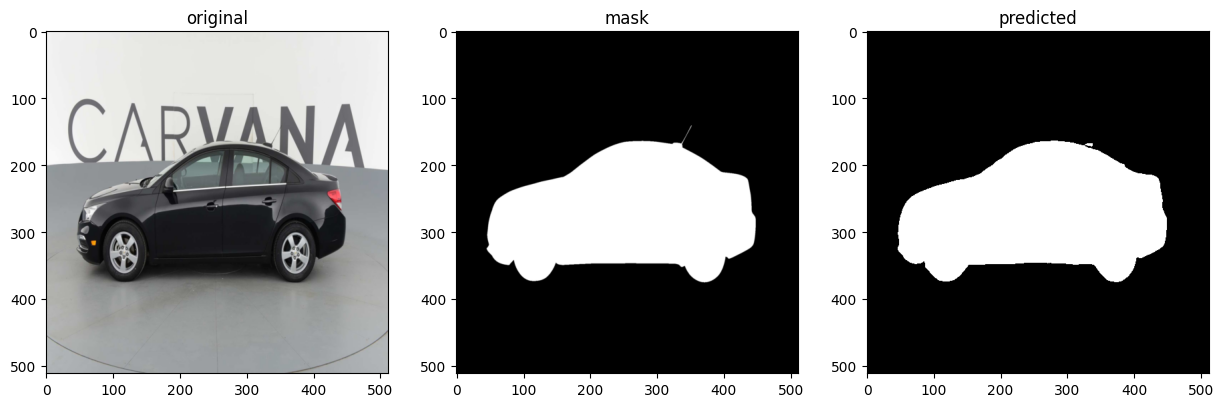

Image: 424658d9f222_16.jpg, DICE coefficient: 0.99302


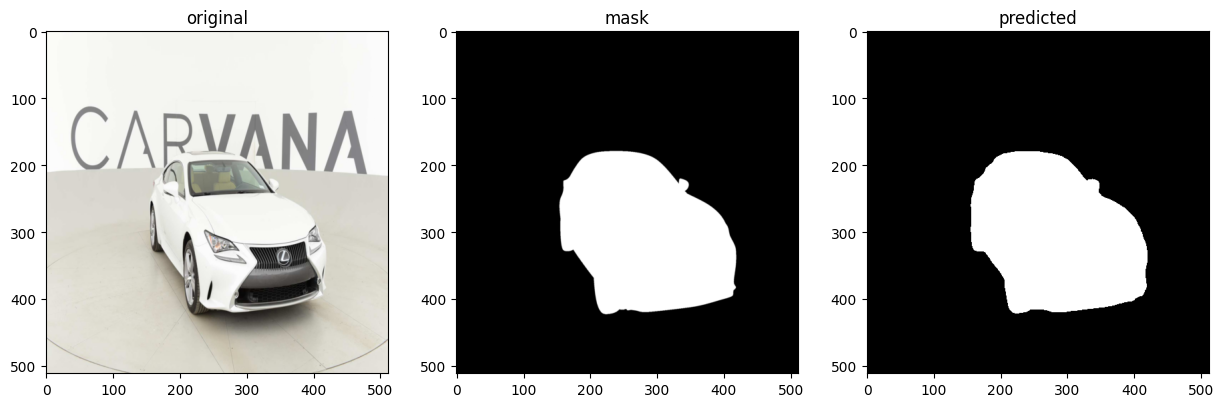

Image: ed13cbcdd5d8_10.jpg, DICE coefficient: 0.98413


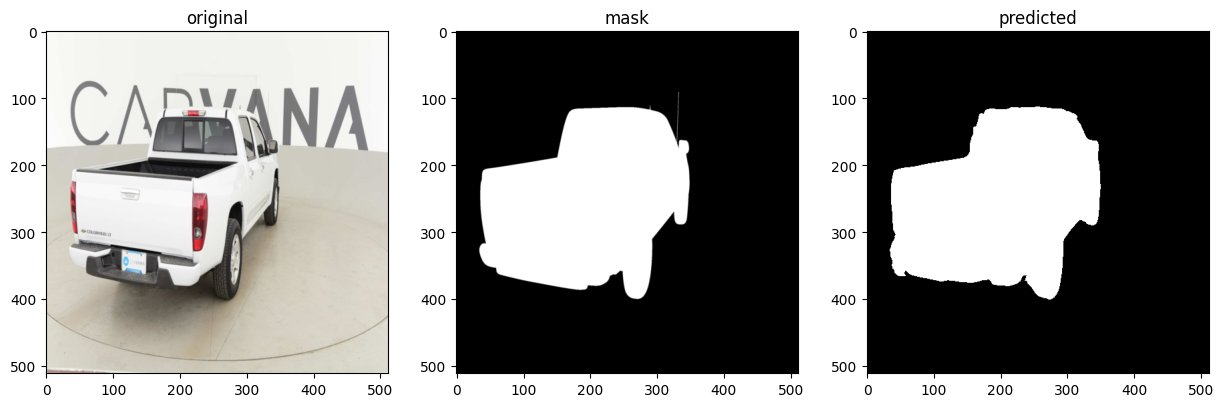

Image: 4dc8a7fe7c02_14.jpg, DICE coefficient: 0.99292


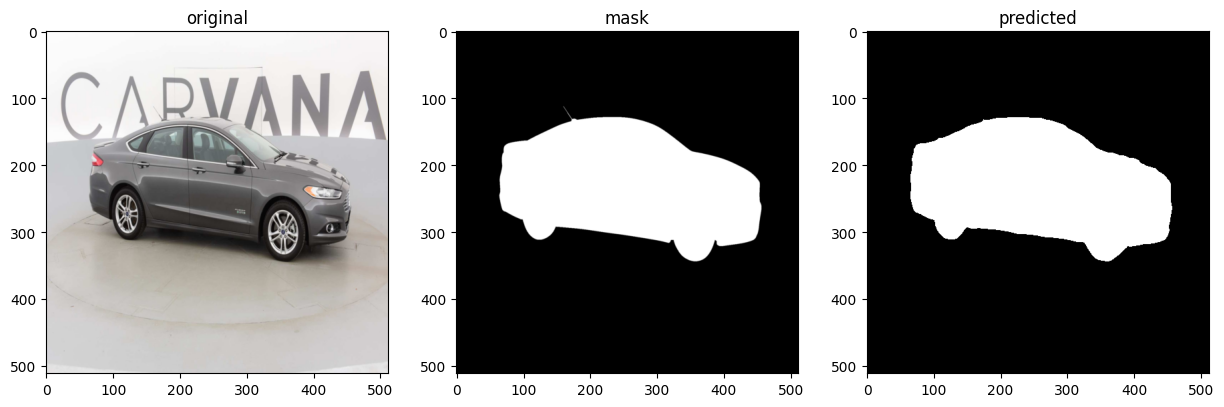

In [66]:
random_images_inference(image_tensors, mask_tensors, image_paths, STATES_DIR + "carvana2.pth", device="cpu")